# [Принятие решений в бизнесе](#1)

**Имеется список гипотез для увеличения выручки. Необходимо их приоритизировать, запустить A/B-тест и проанализировать результаты.**

Описание данных:

Файл /datasets/hypothesis.csv
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

***Оглавление***

**[Приоритизация гипотез](#0)**

[Предобработаем данные](#1)

[Применяем фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета](#2)

[Применяем фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета](#3)

[Узнаем, как изменилась приоритизация гипотез при применении RICE вместо ICE](#4)

**[Анализ A/B-теста](#5)**

[График кумулятивной выручки по группам](#6)

[График кумулятивного среднего чека по группам](#7)

[График относительного изменения кумулятивного среднего чека группы B к группе A](#8)

[График кумулятивного среднего количества заказов на посетителя по группам](#9)

[График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#10)

[Точечный график количества заказов по пользователям](#11)

[95-й и 99-й перцентили количества заказов на пользователя](#12)

[Точечный график стоимостей заказов](#13)

[95-й и 99-й перцентили стоимости заказов](#14)

[Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#15)

[Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#16)

[Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#17)

[Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#18)

**[Выводы](#19)**

<a id='0'></a>
## Приоритизация гипотез.
Задачи:

* Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

<a id='1'></a>
### Предобработаем данные

Импортируем библиотеки, необходимые для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.stats as stats
import math

Открываем файлы

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Просматриваем файлы

In [3]:
hypothesis.sample(5, random_state=13)

,Hypothesis,Reach,Impact,Confidence,Efforts
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3


Изучаем информацию о типах данных

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Выявляем пропуски и дубликаты

In [5]:
pd.DataFrame(round(hypothesis.isna().mean()*100,1))

,0
Hypothesis,0.0
Reach,0.0
Impact,0.0
Confidence,0.0
Efforts,0.0


In [6]:
hypothesis.duplicated().sum()

0

Приводим названия столбцов к общепринятому формату согласно правилам хорошего стиля

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

Аналогично действуем с оставшимися двумя файлами данных

In [8]:
orders.sample(5, random_state=13)

,transactionId,visitorId,date,revenue,group
103,2951399376,2019355024,2019-08-01,2550,B
107,1524568202,1722579998,2019-08-16,8390,A
275,26423654,1229866403,2019-08-23,1940,A
1102,1941707234,199603092,2019-08-12,6438,A
960,2012277167,2999642019,2019-08-10,28750,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
orders['date'] = pd.to_datetime(orders['date']).dt.date 

In [11]:
pd.DataFrame(round(orders.isna().mean()*100,1))

,0
transactionId,0.0
visitorId,0.0
date,0.0
revenue,0.0
group,0.0


In [12]:
orders.duplicated().sum()

0

In [13]:
visitors.sample(5, random_state=13)

,date,group,visitors
55,2019-08-25,B,679
4,2019-08-05,A,756
42,2019-08-12,B,543
14,2019-08-15,A,628
0,2019-08-01,A,719


In [14]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [15]:
visitors['date'] = pd.to_datetime(visitors['date']).dt.date 

In [16]:
pd.DataFrame(round(visitors.isna().mean()*100,1))

,0
date,0.0
group,0.0
visitors,0.0


In [17]:
visitors.duplicated().sum()

0

Убедимся в равномерном распределении пользователей по группам

In [18]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

Найдём срок проведения теста

In [19]:
print('Тест проводился с', min(orders['date']), 'по', max(orders['date']))

Тест проводился с 2019-08-01 по 2019-08-31


Выясним, не попадают ли какие-то пользователи в обе группы

In [20]:
duplicates = orders.duplicated(subset=['transactionId','visitorId'])
orders[duplicates == True]

,transactionId,visitorId,date,revenue,group


In [21]:
groups_df = orders.groupby('visitorId')['group'].nunique().reset_index()
result_df = groups_df.query('group > 1')
result_df

,visitorId,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2
84,351125977,2
97,393266494,2
114,457167155,2
119,471551937,2
122,477780734,2


In [22]:
excluded_ids = result_df['visitorId'].unique()
orders = orders[~orders['visitorId'].isin(excluded_ids)]

**Вывод**

Мы загрузили данные из CSV-файлов в переменные. Изучили их и выполнили предобработку. Убедились, что в данных отсутсвуют пропуски и дубликаты. Скорректировали типы данных в столбцах с датой и временем.

### Применяем фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета
<a id='2'></a>

In [23]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).style.format({'ICE': '{:.2f}'}).background_gradient('coolwarm')

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


<a id='3'></a>
### Применяем фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета

In [24]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).style.format({'RICE': '{:.2f}'}).background_gradient('coolwarm')

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


<a id='4'></a>
### Узнаем, как изменилась приоритизация гипотез при применении RICE вместо ICE

Согласно способу приоритизации ICE в топ-3 попали гипотезы "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Однако при применени способа RICE порядок приоритета слегка изменился: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" и "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей". Это объясняется тем, что в случае использования метода ICE мы не учитывали охват изменений, что в конечном результате и повлияло на приоритизацию.

<a id='5'></a>

## Анализ A/B-теста

Задачи:

Проанализируйте A/B-тест:
* Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
* Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
* Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения.
* Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
* Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
* Построить точечный график стоимостей заказов. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
* Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
* Принять решение по результатам теста и объяснить его. Варианты решений:
   1. Остановить тест, зафиксировать победу одной из групп.
   2. Остановить тест, зафиксировать отсутствие различий между группами.
   3. Продолжить тест.

<a id='6'></a>
### График кумулятивной выручки по группам

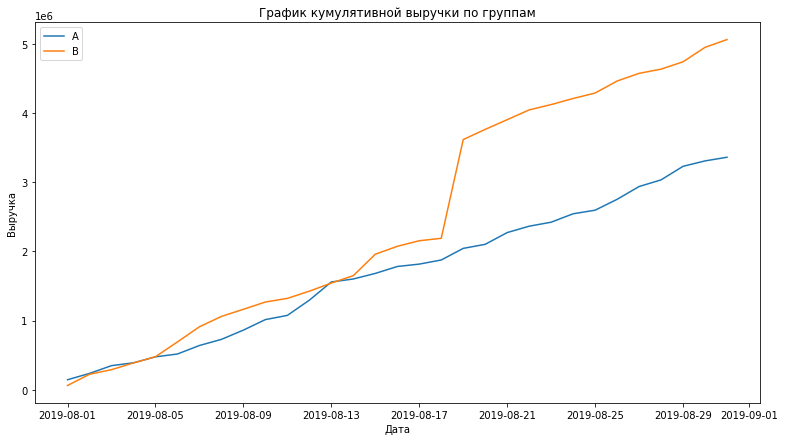

In [25]:
datesGroups = orders[['date', 'group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.rename(columns = {'transactionId' : 'orders', 'visitorId' : 'buyers'}, inplace = True)
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(13, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel("Выручка")
plt.legend()

Выручка увеличивается в течение всего теста. Однако группа B стабильно показывает большую выручку, нежели группа A. Также, если группа А демонстрирует достаточно линейный рост, то в группе B наблюдается резкий подскок, похожий на выброс.

<a id='7'></a>
### График кумулятивного среднего чека по группам

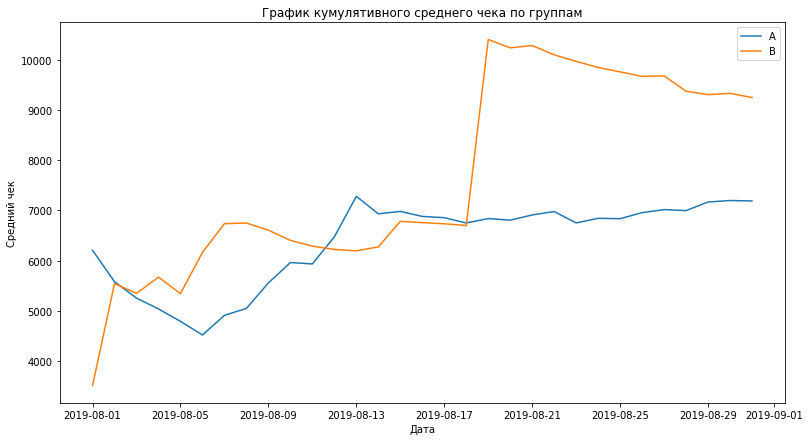

In [26]:
plt.figure(figsize=(13, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel("Средний чек")
plt.legend()

Средний чек группы В на графике также демонстрирует резкий скачок. Возможно, попали крупные заказы.

<a id='8'></a>
### График относительного изменения кумулятивного среднего чека группы B к группе A

Text(0.5, 0, 'Дата')

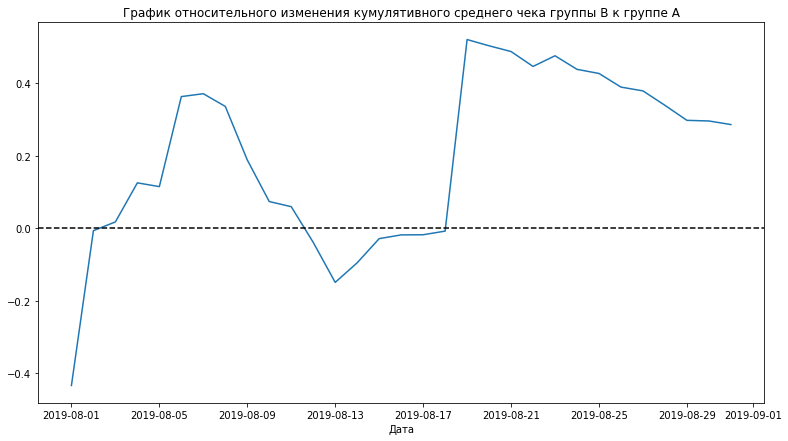

In [27]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(13, 7))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')

Три вышеуказанных графика иллюстрируют, что первого августа группа А лидировала, затем группа В стала демонстрировать более высокие показатели, однако 13 августа группа А снова стала лидером. Однако потом в группе В произошёл резкий рост, возможно, обусловленный аномалией

<a id='9'></a>
### График кумулятивного среднего количества заказов на посетителя по группам

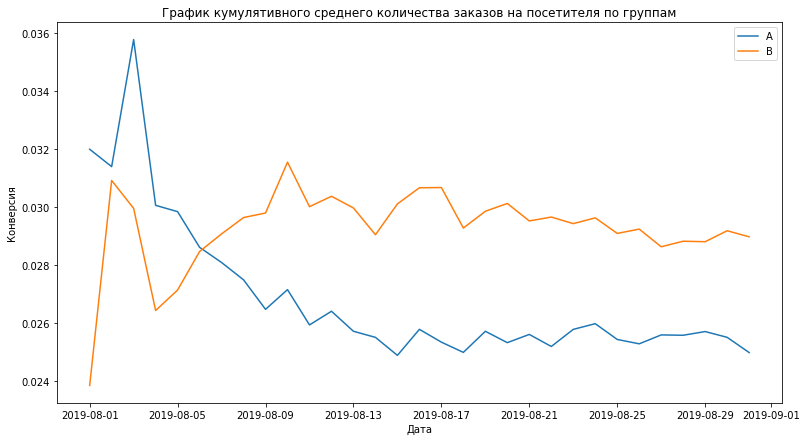

In [28]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(13, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel("Конверсия")
plt.legend()

Поначалу конверсия достаточно сильно колебалась, после девятого августа немного стабилизировалась. Причём конверсия группы В значительно выше конверсии группы А

<a id='10'></a>
### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

No handles with labels found to put in legend.


Text(0, 0.5, 'Конверсия')

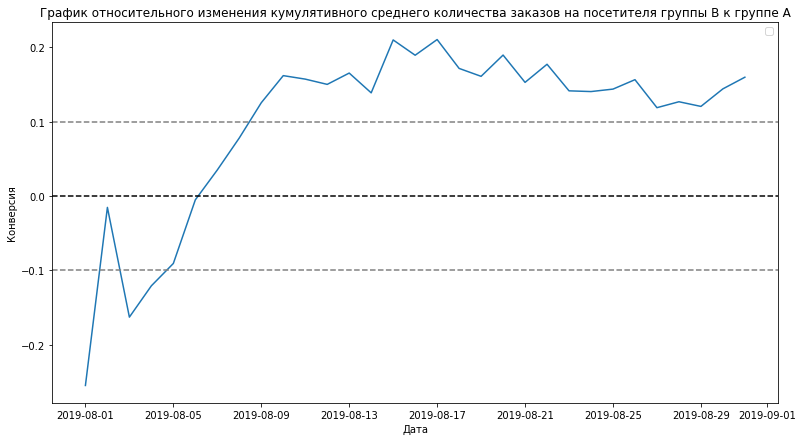

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(13, 7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel("Конверсия")

Подавляющее большинство времени конверсия группы В превышает конверсию группы А больше чем на 10%

<a id='11'></a>
### Точечный график количества заказов по пользователям

Text(0, 0.5, 'Количество заказов')

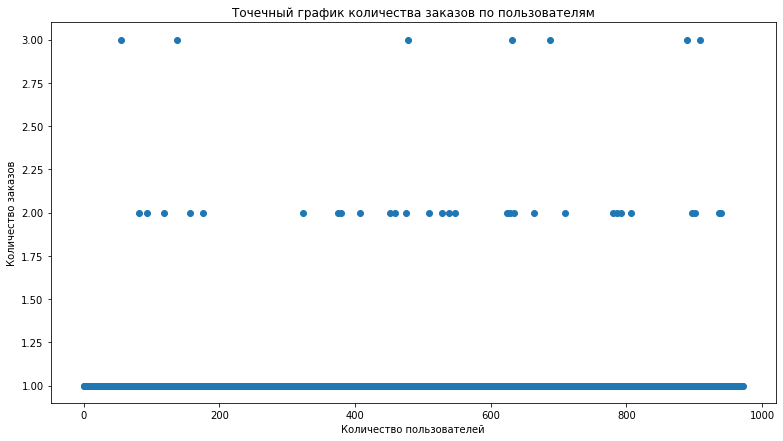

In [30]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'}))
ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(13, 7))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel("Количество заказов")

Большинство клиентов делает по одному заказу, однако два-три заказа также являются нормой. Кроме того, есть и сделавшие более 10 заказов.

<a id='12'></a>
### 95-й и 99-й перцентили количества заказов на пользователя

In [31]:
perc_95_count = np.percentile(ordersByUsers['orders'], 95)
perc_99_count = np.percentile(ordersByUsers['orders'], 99)
print ('95-й перцентиль количества заказов на пользователя: ', perc_95_count)
print ('99-й перцентиль количества заказов на пользователя: ', perc_99_count)

95-й перцентиль количества заказов на пользователя:  1.0
99-й перцентиль количества заказов на пользователя:  2.0


Всего лишь 5% пользователей совершают больше 2 заказов, и только 1% - больше 4.

Отсекаем 1% аномалий - свыше 4 заказов

<a id='13'></a>
### Точечный график стоимостей заказов

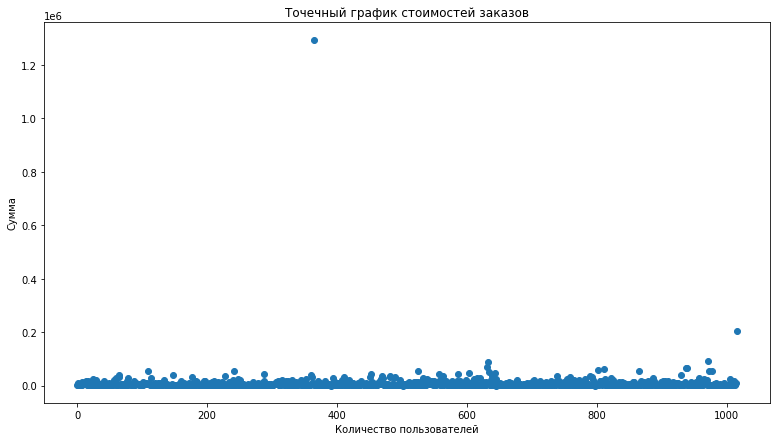

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(13, 7))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel("Сумма")
plt.show()

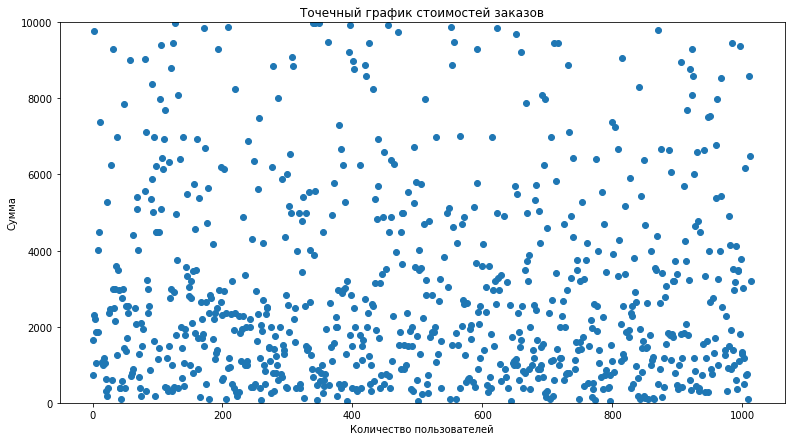

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(13, 7))
plt.scatter(x_values, orders['revenue'])
plt.ylim([0, 10000])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel("Сумма")
plt.show()


Основная масса клиентов делает покупки стоимостью до 10 тысяч. Имеется один заказ на ~ 20 тысяч, и один на ~ 120 тысяч. Вероятно, второй и является тем фактором, который обуславливает скачок на графиках группы В

<a id='14'></a>
### 95-й и 99-й перцентили стоимости заказов

In [34]:
perc_95_sum = np.percentile(orders['revenue'], 95)
perc_99_sum = np.percentile(orders['revenue'], 99)
print ('95-й перцентиль стоимости заказов: ', perc_95_sum)
print ('99-й перцентиль стоимости заказов: ', perc_99_sum)

95-й перцентиль стоимости заказов:  26785.0
99-й перцентиль стоимости заказов:  53904.0


Всего лишь 5% заказов дороже 28000, и только 1% - дороже 58 тысяч

Отсекаем 1% аномалий - заказы свыше 58233.2

<a id='15'></a>
### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезу, которую необходимо проверить:

Гипотеза Н0: среднее количество заказов на посетителя между группами по «сырым» данным равно.

Гипотеза Н1: среднее количество заказов на посетителя между группами по «сырым» данным не равно.

Используем Непараметрический тест Уилкоксона-Манна-Уитни. 

Зададим параметр альфа

In [35]:
alpha = 0.05

In [36]:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
 
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
results = stats.mannwhitneyu(sampleA, sampleB)
print ('P-value = ', round(results.pvalue, 3))
if results.pvalue < alpha:
    print('Разница статистически значима')
else:
    print('Разница статистически не значима')

print('Относительное различие в среднем между группами = '"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


P-value =  0.011
Разница статистически значима
Относительное различие в среднем между группами = 0.160


Мы отвергаем гипотезу Н0, таким образом, среднее количество заказов на посетителя между группами по «сырым» данным не равно

<a id='16'></a>
###  Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезу, которую необходимо проверить:

Гипотеза Н0: средняя сумма чеков между группами по «сырым» данным равны.

Гипотеза Н1: средняя сумма чеков между группами по «сырым» данным не равны.

In [37]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
 
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

print ('P-value = ', round(results.pvalue, 3))

if results.pvalue < alpha:
    print('Разница статистически значима')
else:
    print('Разница статистически не значима')

print('Относительное различие в средних чеках между группами = ''{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


P-value =  0.829
Разница статистически не значима
Относительное различие в средних чеках между группами = 0.287


Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя 

<a id='17'></a>
### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Сформулируем гипотезу, которую необходимо проверить:

Гипотеза Н0: среднее количество заказов на посетителя между группами по «очищенным» данным равно.

Гипотеза Н1: среднее количество заказов на посетителя между группами по «очищенным» данным не равно.

In [38]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > perc_99_count]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > perc_99_count]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > perc_99_sum]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [39]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)

print ('P-value = ', round(results.pvalue, 3))

if results.pvalue < alpha:
    print('Разница статистически значима')
else:
    print('Разница статистически не значима')

print('Относительное различие в среднем между группами = '"{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))


P-value =  0.007
Разница статистически значима
Относительное различие в среднем между группами = 0.189


Мы отвергаем гипотезу Н0, таким образом, среднее количество заказов на посетителя между группами по «очищенным» данным не равно

<a id='18'></a>
### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезу, которую необходимо проверить:

Гипотеза Н0: средняя сумма чеков между группами по «очищенным» данным равны.

Гипотеза Н1: средняя сумма чеков между группами по «очищенным» данным не равны.

In [40]:
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])

print ('P-value = ', round(results.pvalue, 3))


if results.pvalue < alpha:
    print('Разница статистически значима')
else:
    print('Разница статистически не значима')

print('Относительное различие в средних чеках между группами = '"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value =  0.788
Разница статистически не значима
Относительное различие в средних чеках между группами = -0.032


Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.

<a id='19'></a>
### Выводы

Исходя из проведённого ислледования, можно зафиксировать:
* Пользователи равномерно распределены по группам (корректное деление трафика теста)
* Разница в среднем количестве заказов на посетителя между группами как по "сырым", так и по "очищенным" данным статистически значима (13% и 15% соответственно)
* Разница в среднем чеке заказа между группами как по "сырым", так и по "очищенным" данным статистически не значима
* Срок проводимого тестирования - месяц (август). Так как наш товар не подвержен сезонности, а тест проводился не в праздничное время, можно сказать, что данного срока вполне достаточно для корректного анализа

Таким образом, можно остановить тест, зафиксировав победу группы В по показателю конверсии.